# Investigating Spotify reviews
The purpose of this analysis is to identify the most popular words used in reviews for each star category (1-5, with 1 and 5 being the most important ones). Because of the fact, that the reviews are users' input, we are expecting some of the words to be counted incorrectly (because of the spelling errors). We will also prepare some basic analysis to track, how the reviews have been changing over the time.

## 1. Importing raw data and modules

In [1]:
import pandas as pd

raw_data = pd.read_csv('solid-couscous/reviews.csv')
print(raw_data.head())

        Time_submitted                                             Review  \
0  2022-07-09 15:00:00  Great music service, the audio is high quality...   
1  2022-07-09 14:21:22  Please ignore previous negative rating. This a...   
2  2022-07-09 13:27:32  This pop-up "Get the best Spotify experience o...   
3  2022-07-09 13:26:45    Really buggy and terrible to use as of recently   
4  2022-07-09 13:20:49  Dear Spotify why do I get songs that I didn't ...   

   Rating  Total_thumbsup Reply  
0       5               2   NaN  
1       5               1   NaN  
2       4               0   NaN  
3       1               1   NaN  
4       1               1   NaN  


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Checking the overall data distribution

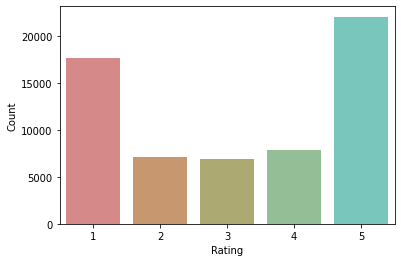

In [3]:
hue_colors = {1: '#e27c7c',
             2: '#d59662',
             3: '#b5b169',
             4: '#8dc68f',
             5: '#6cd4c5',}
hist = sns.countplot(x='Rating', data = raw_data, palette = hue_colors)
hist.set_ylabel('Count')
plt.show()

In [4]:
print(raw_data['Rating'].describe())

count    61594.000000
mean         3.155989
std          1.673285
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64


In [5]:
print(raw_data['Time_submitted'].agg(['min','max']))

min    2022-01-01 00:19:09
max    2022-07-09 15:00:00
Name: Time_submitted, dtype: object


In [6]:
data_trunc = raw_data.copy()
data_trunc['Month'] = pd.to_datetime(data_trunc['Time_submitted']).dt.strftime("%Y-%m")
print(data_trunc.head())

        Time_submitted                                             Review  \
0  2022-07-09 15:00:00  Great music service, the audio is high quality...   
1  2022-07-09 14:21:22  Please ignore previous negative rating. This a...   
2  2022-07-09 13:27:32  This pop-up "Get the best Spotify experience o...   
3  2022-07-09 13:26:45    Really buggy and terrible to use as of recently   
4  2022-07-09 13:20:49  Dear Spotify why do I get songs that I didn't ...   

   Rating  Total_thumbsup Reply    Month  
0       5               2   NaN  2022-07  
1       5               1   NaN  2022-07  
2       4               0   NaN  2022-07  
3       1               1   NaN  2022-07  
4       1               1   NaN  2022-07  


                Time_submitted
Month   Rating                
2022-01 1                 1590
        2                  561
        3                  600
        4                  703
        5                 1777


[Text(0, 0.5, 'Rating Count')]

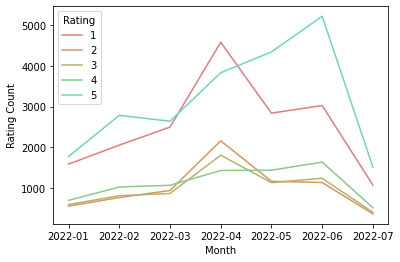

In [7]:
ratings_count_per_month = data_trunc[['Month','Rating','Time_submitted']].groupby(by = ['Month','Rating']).count()
print(ratings_count_per_month.head())
ax = sns.lineplot(data = ratings_count_per_month, x = 'Month', y = 'Time_submitted', hue = 'Rating', palette = hue_colors)
ax.set(ylabel = 'Rating Count')

## 3. Creating word clouds of the reviews by rating

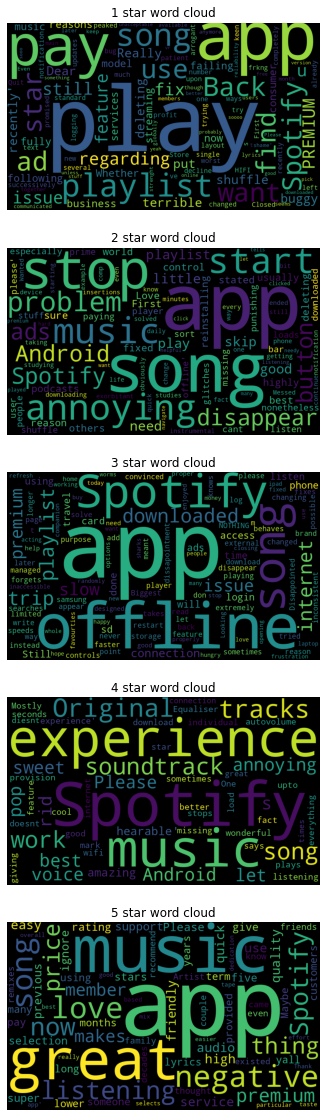

In [8]:
# from collections import Counter
from wordcloud import WordCloud

words_1_star = data_trunc['Review'][data_trunc['Rating'] == 1].values
wordcloud_1_star = WordCloud(width = 1000, height = 600, stopwords = None).generate(str(words_1_star))
words_2_star = data_trunc['Review'][data_trunc['Rating'] == 2].values
wordcloud_2_star = WordCloud(width = 1000, height = 600, stopwords = None).generate(str(words_2_star))
words_3_star = data_trunc['Review'][data_trunc['Rating'] == 3].values
wordcloud_3_star = WordCloud(width = 1000, height = 600, stopwords = None).generate(str(words_3_star))
words_4_star = data_trunc['Review'][data_trunc['Rating'] == 4].values
wordcloud_4_star = WordCloud(width = 1000, height = 600, stopwords = None).generate(str(words_4_star))
words_5_star = data_trunc['Review'][data_trunc['Rating'] == 5].values
wordcloud_5_star = WordCloud(width = 1000, height = 600, stopwords = None).generate(str(words_5_star))

f, axarr = plt.subplots(5,1)

f.set_figheight(20)
f.set_figwidth(10)

axarr[0].imshow(wordcloud_1_star)
axarr[1].imshow(wordcloud_2_star)
axarr[2].imshow(wordcloud_3_star)
axarr[3].imshow(wordcloud_4_star)
axarr[4].imshow(wordcloud_5_star)
for i in range(5):
    axarr[i].axis("off")
    axarr[i].set_title(str(i+1) + " star word cloud")
plt.show()

f.savefig('full_figure.png', dpi=200)

# top_1_star_words = Counter(" ".join(data_trunc[data_trunc['Rating'] == 1]["Review"].str.lower()).split())
# top_2_star_words = Counter(" ".join(data_trunc[data_trunc['Rating'] == 2]["Review"].str.lower()).split())
# top_3_star_words = Counter(" ".join(data_trunc[data_trunc['Rating'] == 3]["Review"].str.lower()).split())
# top_4_star_words = Counter(" ".join(data_trunc[data_trunc['Rating'] == 4]["Review"].str.lower()).split())
# top_5_star_words = Counter(" ".join(data_trunc[data_trunc['Rating'] == 5]["Review"].str.lower()).split())

# words_to_exclude = ('the','to','i','and','it','a','app','is','my','this','for','of','you','on','not','but','in','have','song','play','songs','spotify','that','music',"can't",'when','just','even','so','with',"it's",'or','me','no','listen','if','premium','now','are','playing',"don't")

## 4. Constructing machine learning model to figure out sentiment

In [9]:
conditions = [
    (data_trunc['Rating'] < 3),
    (data_trunc['Rating'] == 3),
    (data_trunc['Rating'] > 3)
    ]

# create a list of the values we want to assign for each condition
values = ['negative', 'neutral', 'positive']

# create a new column and use np.select to assign values to it using our lists as arguments
data_trunc['Sentiment'] = np.select(conditions, values)

print(data_trunc.head())

        Time_submitted                                             Review  \
0  2022-07-09 15:00:00  Great music service, the audio is high quality...   
1  2022-07-09 14:21:22  Please ignore previous negative rating. This a...   
2  2022-07-09 13:27:32  This pop-up "Get the best Spotify experience o...   
3  2022-07-09 13:26:45    Really buggy and terrible to use as of recently   
4  2022-07-09 13:20:49  Dear Spotify why do I get songs that I didn't ...   

   Rating  Total_thumbsup Reply    Month Sentiment  
0       5               2   NaN  2022-07  positive  
1       5               1   NaN  2022-07  positive  
2       4               0   NaN  2022-07  positive  
3       1               1   NaN  2022-07  negative  
4       1               1   NaN  2022-07  negative  


In [10]:
features = data_trunc['Review']
labels = data_trunc['Sentiment']

In [11]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [13]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [15]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [16]:
predictions = text_classifier.predict(X_test)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[4412    8  581]
 [ 948    2  404]
 [ 889    6 5069]]
              precision    recall  f1-score   support

    negative       0.71      0.88      0.78      5001
     neutral       0.12      0.00      0.00      1354
    positive       0.84      0.85      0.84      5964

    accuracy                           0.77     12319
   macro avg       0.56      0.58      0.54     12319
weighted avg       0.71      0.77      0.73     12319

0.7697865086451823
